# Importamos librerías

In [2]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [5]:
path = '../../../Base de datos/Trayectorias 100 eval'

## Datos de entrenamiento

### Datos

In [6]:
varftrain = np.load(path + '/varftrain.npy')

In [7]:
np.shape(varftrain)

(7000, 10, 2, 100)

### Coeficientes

In [8]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [9]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [10]:
varftest = np.load(path + '/varftest.npy')

In [11]:
np.shape(varftest)

(2000, 10, 2, 100)

### Coeficientes

In [12]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [13]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [14]:
varfval = np.load(path + '/varfval.npy')

In [15]:
np.shape(varfval)

(1000, 10, 2, 100)

### Coeficienes

In [16]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [17]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [19]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(10, 2, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [20]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,2,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation=custom_activation)
])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2000)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 2000)             8000      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 100)               200100    
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 25)                1275      
                                                                 
 dense_8 (Dense)             (None, 50)                1300      
                                                      

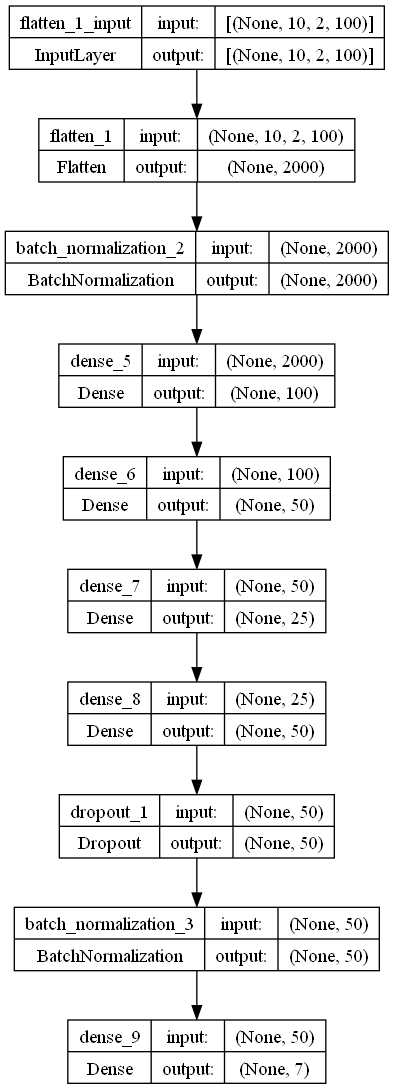

In [25]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [28]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [29]:
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])

In [30]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [31]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, 
                    callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 1s 4ms/step - loss: 7.5625 - mae: 2.5564 - val_loss: 5.9727 - val_mae: 2.4178 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.9109 - mae: 2.2599 - val_loss: 4.0416 - val_mae: 2.0685 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.8735 - mae: 2.1782 - val_loss: 3.4980 - val_mae: 2.0070 - lr: 0.0010
Epoch 4/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.5065 - mae: 2.1323 - val_loss: 3.3017 - val_mae: 1.9957 - lr: 0.0010
Epoch 5/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.2917 - mae: 2.0629 - val_loss: 3.1167 - val_mae: 1.9471 - lr: 0.0010
Epoch 6/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.2102 - mae: 2.0453 - val_loss: 3.0294 - val_mae: 1.9226 - lr: 0.0010
Epoch 7/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.0687 - mae: 1.9963 - val_loss: 3.0758 - val_mae: 2.054

70/70 [==============================] - 0s 3ms/step - loss: 1.8353 - mae: 1.6522 - val_loss: 1.7327 - val_mae: 1.5511 - lr: 0.0010
Epoch 58/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.8271 - mae: 1.6451 - val_loss: 1.7104 - val_mae: 1.5301 - lr: 0.0010
Epoch 59/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.8172 - mae: 1.6378 - val_loss: 1.7031 - val_mae: 1.5243 - lr: 0.0010
Epoch 60/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.8155 - mae: 1.6365 - val_loss: 1.6807 - val_mae: 1.5079 - lr: 0.0010
Epoch 61/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.8060 - mae: 1.6337 - val_loss: 1.6908 - val_mae: 1.5181 - lr: 0.0010
Epoch 62/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.8202 - mae: 1.6443 - val_loss: 1.7111 - val_mae: 1.5359 - lr: 0.0010
Epoch 63/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.8002 - mae: 1.6287 - val_loss: 1.6688 - val_mae: 1.5040 - lr:

70/70 [==============================] - 0s 3ms/step - loss: 1.7391 - mae: 1.6057 - val_loss: 1.6178 - val_mae: 1.4867 - lr: 0.0010
Epoch 114/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7550 - mae: 1.6227 - val_loss: 1.6197 - val_mae: 1.4892 - lr: 0.0010
Epoch 115/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7515 - mae: 1.6202 - val_loss: 1.6361 - val_mae: 1.5028 - lr: 0.0010
Epoch 116/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7426 - mae: 1.6089 - val_loss: 1.5836 - val_mae: 1.4536 - lr: 0.0010
Epoch 117/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7388 - mae: 1.6067 - val_loss: 1.6122 - val_mae: 1.4809 - lr: 0.0010
Epoch 118/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7571 - mae: 1.6213 - val_loss: 1.6527 - val_mae: 1.5177 - lr: 0.0010
Epoch 119/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7497 - mae: 1.6121 - val_loss: 1.5885 - val_mae: 1.4510

Epoch 169/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7259 - mae: 1.6043 - val_loss: 1.5797 - val_mae: 1.4592 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7222 - mae: 1.6027 - val_loss: 1.5783 - val_mae: 1.4606 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7233 - mae: 1.6066 - val_loss: 1.5691 - val_mae: 1.4534 - lr: 0.0010
Epoch 172/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7336 - mae: 1.6160 - val_loss: 1.5880 - val_mae: 1.4708 - lr: 0.0010
Epoch 173/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7160 - mae: 1.5975 - val_loss: 1.5684 - val_mae: 1.4503 - lr: 0.0010
Epoch 174/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7180 - mae: 1.5992 - val_loss: 1.5787 - val_mae: 1.4622 - lr: 0.0010
Epoch 175/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7067 - mae: 1.5887 - val_loss: 1.5938 - 

Epoch 225/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7148 - mae: 1.5984 - val_loss: 1.5607 - val_mae: 1.4469 - lr: 0.0010
Epoch 226/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7120 - mae: 1.5994 - val_loss: 1.5648 - val_mae: 1.4536 - lr: 0.0010
Epoch 227/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7133 - mae: 1.6020 - val_loss: 1.5835 - val_mae: 1.4728 - lr: 0.0010
Epoch 228/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7006 - mae: 1.5896 - val_loss: 1.5939 - val_mae: 1.4832 - lr: 0.0010
Epoch 229/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7042 - mae: 1.5927 - val_loss: 1.5714 - val_mae: 1.4593 - lr: 0.0010
Epoch 230/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7127 - mae: 1.5991 - val_loss: 1.5632 - val_mae: 1.4504 - lr: 0.0010
Epoch 231/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7159 - mae: 1.6009 - val_loss: 1.5444 - 

Epoch 281/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6954 - mae: 1.5860 - val_loss: 1.5442 - val_mae: 1.4359 - lr: 0.0010
Epoch 282/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7051 - mae: 1.5961 - val_loss: 1.5877 - val_mae: 1.4797 - lr: 0.0010
Epoch 283/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7138 - mae: 1.6033 - val_loss: 1.5769 - val_mae: 1.4653 - lr: 0.0010
Epoch 284/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7077 - mae: 1.5958 - val_loss: 1.5715 - val_mae: 1.4615 - lr: 0.0010
Epoch 285/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7097 - mae: 1.5964 - val_loss: 1.5602 - val_mae: 1.4497 - lr: 0.0010
Epoch 286/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6943 - mae: 1.5836 - val_loss: 1.5469 - val_mae: 1.4369 - lr: 0.0010
Epoch 287/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7109 - mae: 1.5982 - val_loss: 1.5557 - 

Epoch 337/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6940 - mae: 1.5879 - val_loss: 1.5396 - val_mae: 1.4344 - lr: 0.0010
Epoch 338/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6976 - mae: 1.5883 - val_loss: 1.5513 - val_mae: 1.4434 - lr: 0.0010
Epoch 339/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.7016 - mae: 1.5949 - val_loss: 1.5748 - val_mae: 1.4704 - lr: 0.0010
Epoch 340/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6962 - mae: 1.5919 - val_loss: 1.5543 - val_mae: 1.4511 - lr: 0.0010
Epoch 341/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6892 - mae: 1.5854 - val_loss: 1.5567 - val_mae: 1.4527 - lr: 0.0010
Epoch 342/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6900 - mae: 1.5842 - val_loss: 1.5469 - val_mae: 1.4409 - lr: 0.0010
Epoch 343/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6976 - mae: 1.5906 - val_loss: 1.5432 - 

Epoch 393/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6840 - mae: 1.5784 - val_loss: 1.5388 - val_mae: 1.4338 - lr: 0.0010
Epoch 394/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6945 - mae: 1.5888 - val_loss: 1.5675 - val_mae: 1.4629 - lr: 0.0010
Epoch 395/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6976 - mae: 1.5923 - val_loss: 1.5377 - val_mae: 1.4354 - lr: 0.0010
Epoch 396/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6843 - mae: 1.5826 - val_loss: 1.5474 - val_mae: 1.4465 - lr: 0.0010
Epoch 397/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6787 - mae: 1.5780 - val_loss: 1.5253 - val_mae: 1.4257 - lr: 0.0010
Epoch 398/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6713 - mae: 1.5713 - val_loss: 1.5238 - val_mae: 1.4242 - lr: 0.0010
Epoch 399/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6811 - mae: 1.5804 - val_loss: 1.5395 - 

70/70 [==============================] - 0s 3ms/step - loss: 1.6710 - mae: 1.5747 - val_loss: 1.5289 - val_mae: 1.4328 - lr: 9.2410e-04
Epoch 448/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6736 - mae: 1.5769 - val_loss: 1.5456 - val_mae: 1.4479 - lr: 9.2245e-04
Epoch 449/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6741 - mae: 1.5758 - val_loss: 1.5268 - val_mae: 1.4287 - lr: 9.2080e-04
Epoch 450/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6859 - mae: 1.5878 - val_loss: 1.5345 - val_mae: 1.4372 - lr: 9.1915e-04
Epoch 451/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6879 - mae: 1.5902 - val_loss: 1.5424 - val_mae: 1.4437 - lr: 9.1750e-04
Epoch 452/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6749 - mae: 1.5747 - val_loss: 1.5185 - val_mae: 1.4184 - lr: 9.1585e-04
Epoch 453/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6730 - mae: 1.5748 - val_loss: 

70/70 [==============================] - 0s 4ms/step - loss: 1.6651 - mae: 1.5698 - val_loss: 1.5236 - val_mae: 1.4278 - lr: 8.3500e-04
Epoch 502/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6707 - mae: 1.5750 - val_loss: 1.5283 - val_mae: 1.4338 - lr: 8.3335e-04
Epoch 503/1000
70/70 [==============================] - 0s 4ms/step - loss: 1.6727 - mae: 1.5767 - val_loss: 1.5321 - val_mae: 1.4371 - lr: 8.3170e-04
Epoch 504/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6607 - mae: 1.5667 - val_loss: 1.5314 - val_mae: 1.4386 - lr: 8.3005e-04
Epoch 505/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6715 - mae: 1.5784 - val_loss: 1.5302 - val_mae: 1.4378 - lr: 8.2840e-04
Epoch 506/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6678 - mae: 1.5742 - val_loss: 1.5151 - val_mae: 1.4216 - lr: 8.2675e-04
Epoch 507/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6722 - mae: 1.5766 - val_loss: 

70/70 [==============================] - 0s 4ms/step - loss: 1.6511 - mae: 1.5621 - val_loss: 1.5279 - val_mae: 1.4392 - lr: 7.4590e-04
Epoch 556/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6550 - mae: 1.5661 - val_loss: 1.5370 - val_mae: 1.4482 - lr: 7.4425e-04
Epoch 557/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6610 - mae: 1.5708 - val_loss: 1.5194 - val_mae: 1.4285 - lr: 7.4260e-04
Epoch 558/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6642 - mae: 1.5724 - val_loss: 1.5280 - val_mae: 1.4354 - lr: 7.4095e-04
Epoch 559/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6601 - mae: 1.5672 - val_loss: 1.5179 - val_mae: 1.4266 - lr: 7.3930e-04
Epoch 560/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6535 - mae: 1.5626 - val_loss: 1.5096 - val_mae: 1.4186 - lr: 7.3765e-04
Epoch 561/1000
70/70 [==============================] - 0s 4ms/step - loss: 1.6546 - mae: 1.5638 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.6527 - mae: 1.5672 - val_loss: 1.4991 - val_mae: 1.4135 - lr: 6.5680e-04
Epoch 610/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6490 - mae: 1.5631 - val_loss: 1.4953 - val_mae: 1.4102 - lr: 6.5515e-04
Epoch 611/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6476 - mae: 1.5627 - val_loss: 1.5035 - val_mae: 1.4191 - lr: 6.5350e-04
Epoch 612/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6442 - mae: 1.5597 - val_loss: 1.4964 - val_mae: 1.4117 - lr: 6.5185e-04
Epoch 613/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6418 - mae: 1.5565 - val_loss: 1.5007 - val_mae: 1.4148 - lr: 6.5020e-04
Epoch 614/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6512 - mae: 1.5645 - val_loss: 1.5112 - val_mae: 1.4245 - lr: 6.4855e-04
Epoch 615/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6486 - mae: 1.5609 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.6441 - mae: 1.5620 - val_loss: 1.4922 - val_mae: 1.4106 - lr: 5.6770e-04
Epoch 664/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6394 - mae: 1.5581 - val_loss: 1.4821 - val_mae: 1.4012 - lr: 5.6605e-04
Epoch 665/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6445 - mae: 1.5633 - val_loss: 1.4861 - val_mae: 1.4050 - lr: 5.6440e-04
Epoch 666/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6459 - mae: 1.5641 - val_loss: 1.4911 - val_mae: 1.4095 - lr: 5.6275e-04
Epoch 667/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6372 - mae: 1.5557 - val_loss: 1.4832 - val_mae: 1.4024 - lr: 5.6110e-04
Epoch 668/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6402 - mae: 1.5588 - val_loss: 1.4991 - val_mae: 1.4179 - lr: 5.5945e-04
Epoch 669/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6448 - mae: 1.5631 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.6429 - mae: 1.5649 - val_loss: 1.4792 - val_mae: 1.4015 - lr: 4.7860e-04
Epoch 718/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6347 - mae: 1.5566 - val_loss: 1.4823 - val_mae: 1.4039 - lr: 4.7695e-04
Epoch 719/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6261 - mae: 1.5483 - val_loss: 1.4808 - val_mae: 1.4033 - lr: 4.7530e-04
Epoch 720/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6310 - mae: 1.5531 - val_loss: 1.4854 - val_mae: 1.4076 - lr: 4.7365e-04
Epoch 721/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6348 - mae: 1.5567 - val_loss: 1.4809 - val_mae: 1.4030 - lr: 4.7200e-04
Epoch 722/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6374 - mae: 1.5590 - val_loss: 1.4796 - val_mae: 1.4014 - lr: 4.7035e-04
Epoch 723/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6312 - mae: 1.5529 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.6244 - mae: 1.5493 - val_loss: 1.4682 - val_mae: 1.3934 - lr: 3.8950e-04
Epoch 772/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6238 - mae: 1.5490 - val_loss: 1.4703 - val_mae: 1.3957 - lr: 3.8785e-04
Epoch 773/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6272 - mae: 1.5523 - val_loss: 1.4806 - val_mae: 1.4059 - lr: 3.8620e-04
Epoch 774/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6141 - mae: 1.5393 - val_loss: 1.4647 - val_mae: 1.3903 - lr: 3.8455e-04
Epoch 775/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6237 - mae: 1.5493 - val_loss: 1.4704 - val_mae: 1.3961 - lr: 3.8290e-04
Epoch 776/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6186 - mae: 1.5445 - val_loss: 1.4698 - val_mae: 1.3957 - lr: 3.8125e-04
Epoch 777/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6218 - mae: 1.5478 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.6294 - mae: 1.5583 - val_loss: 1.4695 - val_mae: 1.3985 - lr: 3.0040e-04
Epoch 826/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6213 - mae: 1.5502 - val_loss: 1.4628 - val_mae: 1.3919 - lr: 2.9875e-04
Epoch 827/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6241 - mae: 1.5533 - val_loss: 1.4653 - val_mae: 1.3946 - lr: 2.9710e-04
Epoch 828/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6202 - mae: 1.5493 - val_loss: 1.4643 - val_mae: 1.3935 - lr: 2.9545e-04
Epoch 829/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6156 - mae: 1.5447 - val_loss: 1.4594 - val_mae: 1.3886 - lr: 2.9380e-04
Epoch 830/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6128 - mae: 1.5419 - val_loss: 1.4683 - val_mae: 1.3972 - lr: 2.9215e-04
Epoch 831/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6157 - mae: 1.5447 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.6131 - mae: 1.5454 - val_loss: 1.4601 - val_mae: 1.3924 - lr: 2.1130e-04
Epoch 880/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6213 - mae: 1.5536 - val_loss: 1.4624 - val_mae: 1.3948 - lr: 2.0965e-04
Epoch 881/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6188 - mae: 1.5510 - val_loss: 1.4499 - val_mae: 1.3823 - lr: 2.0800e-04
Epoch 882/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6131 - mae: 1.5455 - val_loss: 1.4534 - val_mae: 1.3859 - lr: 2.0635e-04
Epoch 883/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6122 - mae: 1.5446 - val_loss: 1.4514 - val_mae: 1.3839 - lr: 2.0470e-04
Epoch 884/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6132 - mae: 1.5456 - val_loss: 1.4552 - val_mae: 1.3877 - lr: 2.0305e-04
Epoch 885/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6115 - mae: 1.5440 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.6038 - mae: 1.5389 - val_loss: 1.4418 - val_mae: 1.3770 - lr: 1.2220e-04
Epoch 934/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6001 - mae: 1.5353 - val_loss: 1.4422 - val_mae: 1.3774 - lr: 1.2055e-04
Epoch 935/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6036 - mae: 1.5388 - val_loss: 1.4409 - val_mae: 1.3762 - lr: 1.1890e-04
Epoch 936/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6083 - mae: 1.5436 - val_loss: 1.4437 - val_mae: 1.3791 - lr: 1.1725e-04
Epoch 937/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6023 - mae: 1.5377 - val_loss: 1.4425 - val_mae: 1.3780 - lr: 1.1560e-04
Epoch 938/1000
70/70 [==============================] - 0s 4ms/step - loss: 1.6012 - mae: 1.5367 - val_loss: 1.4422 - val_mae: 1.3777 - lr: 1.1395e-04
Epoch 939/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6106 - mae: 1.5460 - val_loss: 

70/70 [==============================] - 0s 3ms/step - loss: 1.6034 - mae: 1.5411 - val_loss: 1.4361 - val_mae: 1.3739 - lr: 3.3100e-05
Epoch 988/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5999 - mae: 1.5376 - val_loss: 1.4374 - val_mae: 1.3752 - lr: 3.1450e-05
Epoch 989/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6153 - mae: 1.5530 - val_loss: 1.4383 - val_mae: 1.3762 - lr: 2.9800e-05
Epoch 990/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6125 - mae: 1.5503 - val_loss: 1.4385 - val_mae: 1.3764 - lr: 2.8150e-05
Epoch 991/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5939 - mae: 1.5318 - val_loss: 1.4377 - val_mae: 1.3756 - lr: 2.6500e-05
Epoch 992/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.6031 - mae: 1.5410 - val_loss: 1.4374 - val_mae: 1.3753 - lr: 2.4850e-05
Epoch 993/1000
70/70 [==============================] - 0s 3ms/step - loss: 1.5954 - mae: 1.5333 - val_loss: 

# Analizamos accuracy y loss

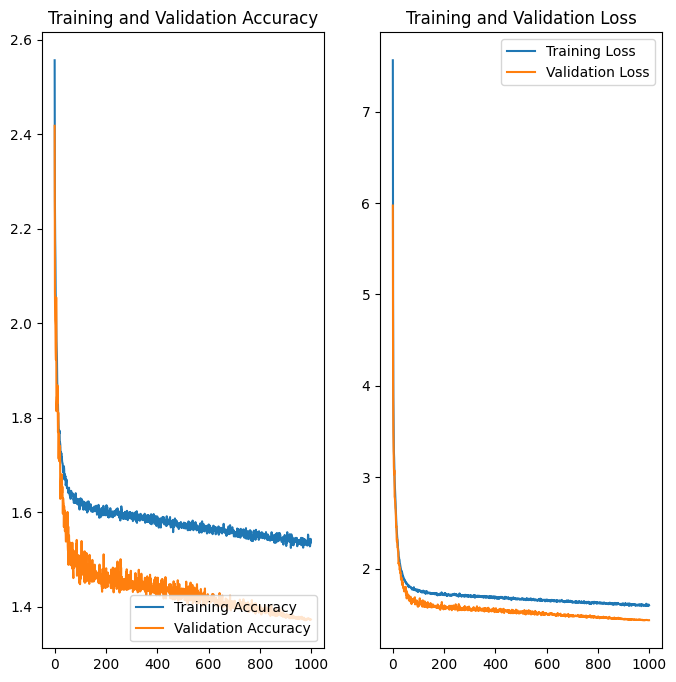

In [32]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [33]:
test_loss, test_acc = model.evaluate(varfval,coefvarfval)

32/32 [==============================] - 0s 836us/step - loss: 1.4352 - mae: 1.3735


In [34]:
predictions = model.predict(varfval)

32/32 [==============================] - 0s 772us/step


In [35]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarfval, predictions)

# Calcula la desviación estándar del error
error = coefvarfval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.3734679014486193, Desviación estándar del error: 1.9906285956364171, Error absoluto máximo: 7.608684301376343


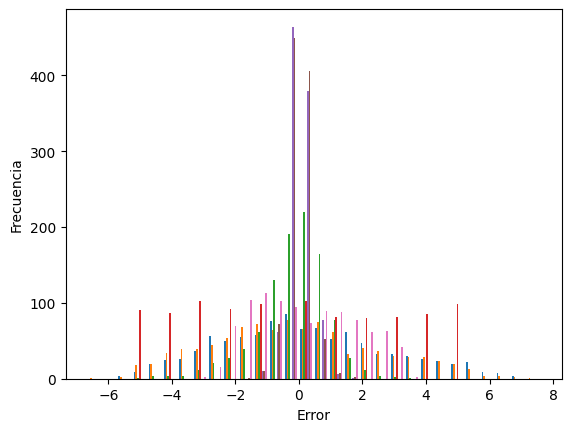

In [36]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [37]:
from sklearn.metrics import r2_score
r2 = r2_score(coefvarfval, predictions)
r2

0.5155056075617978

In [38]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

3.836910820007326

# Guardamos los datos Accuracy y Loss

In [39]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 50,100/historytrayec100.csv', index=False)

# Guardamos el modelo

In [40]:
path_to_save = '../../../Modelos/Modelos 50,100'

In [41]:
model.save(path_to_save + '/trayectorias100.h5')

# Importamos el modelo

In [42]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [43]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 50,100/trayectorias100.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [50]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[1, 8, 5, 8, 10, 2, 3]
(10, 2, 100)


In [51]:
varfnone = varf[None, :]

## Predecimos con los datos nuevos

In [52]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 11ms/step
[[ 4.  9.  4.  5. 10.  2.  4.]]


## Graficamos con los coeficientes reales

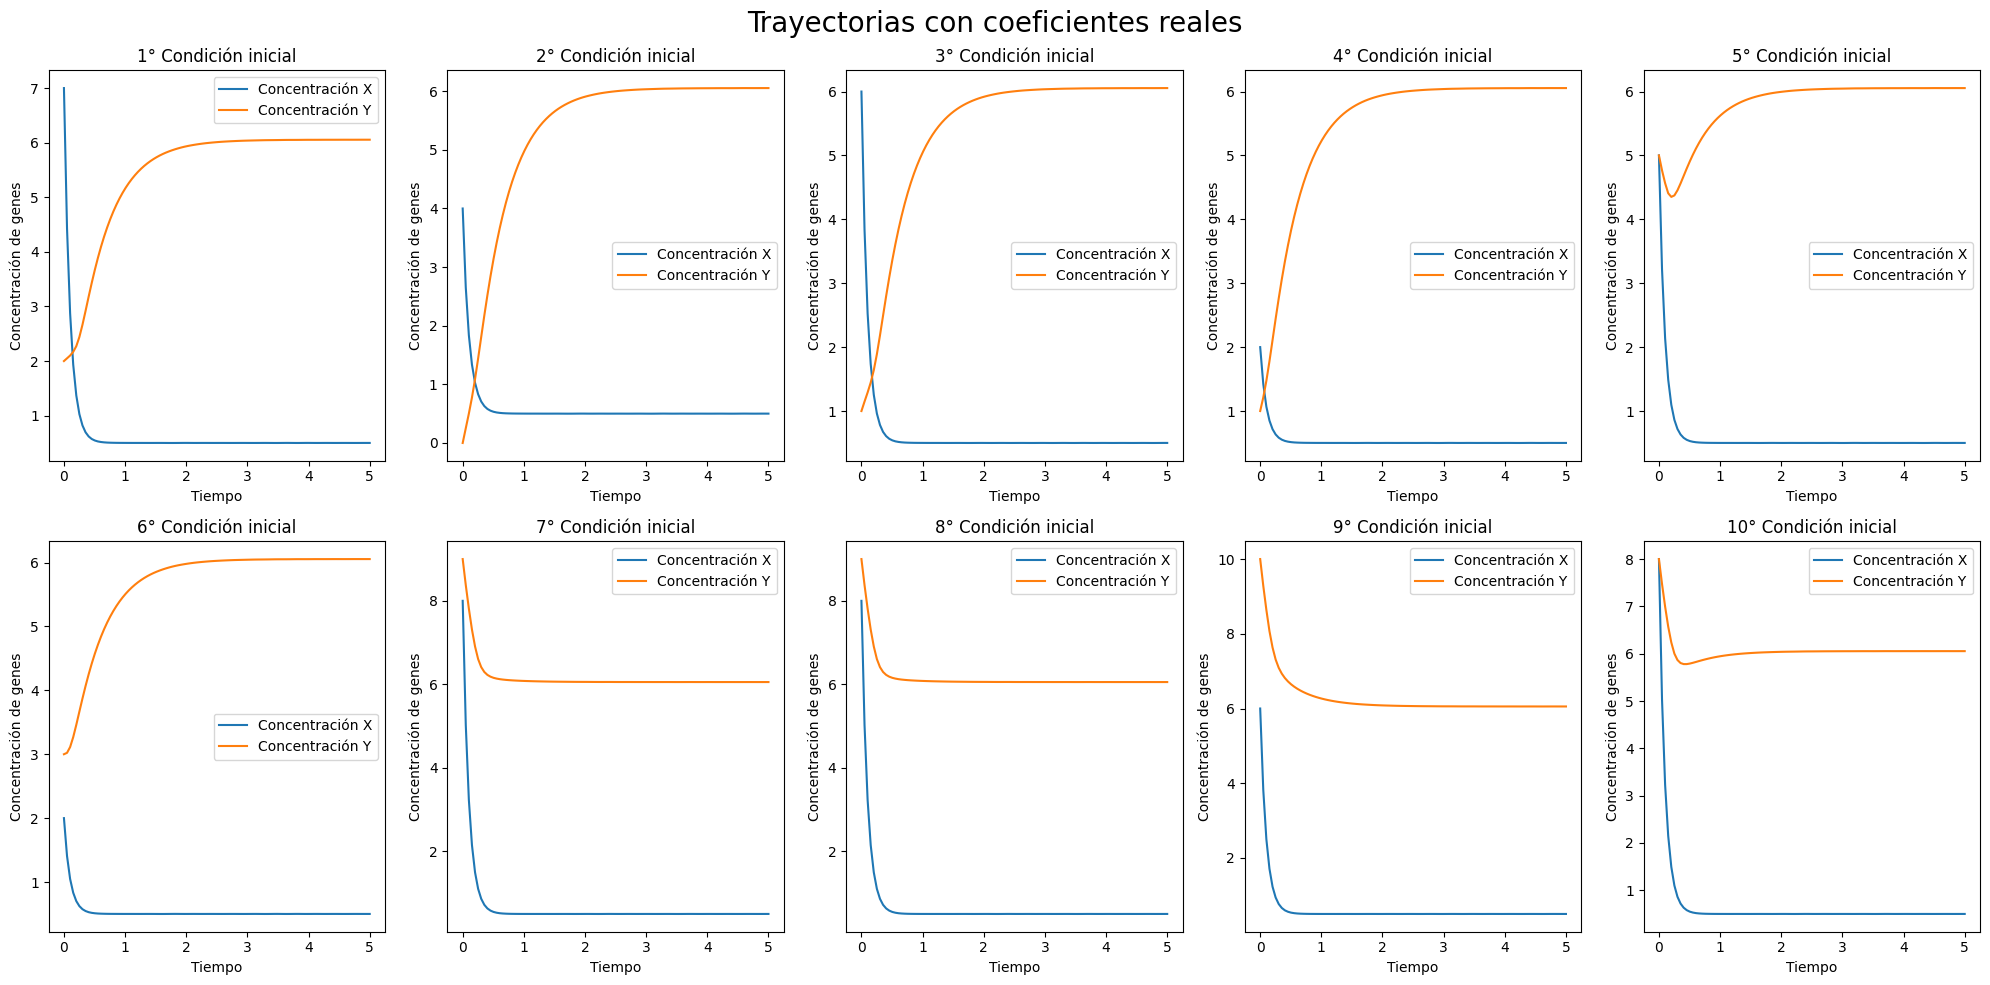

In [53]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [54]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

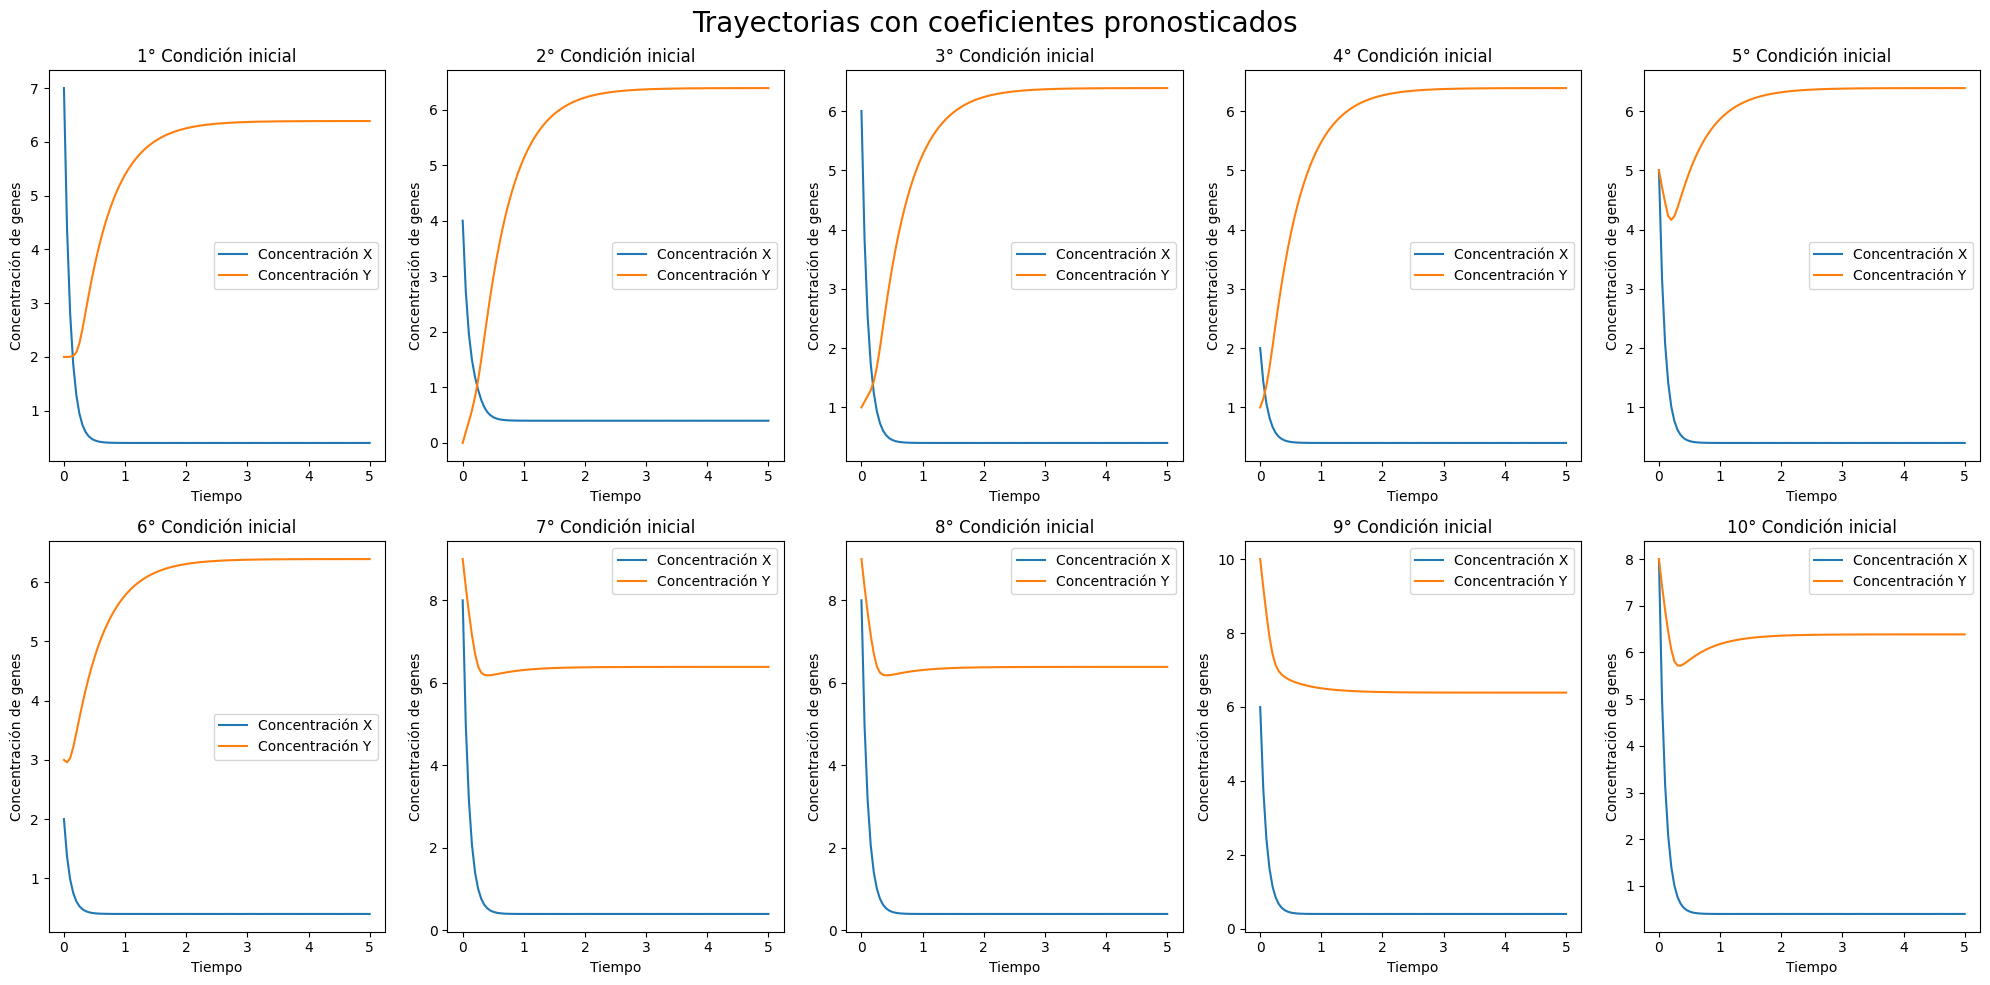

In [55]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

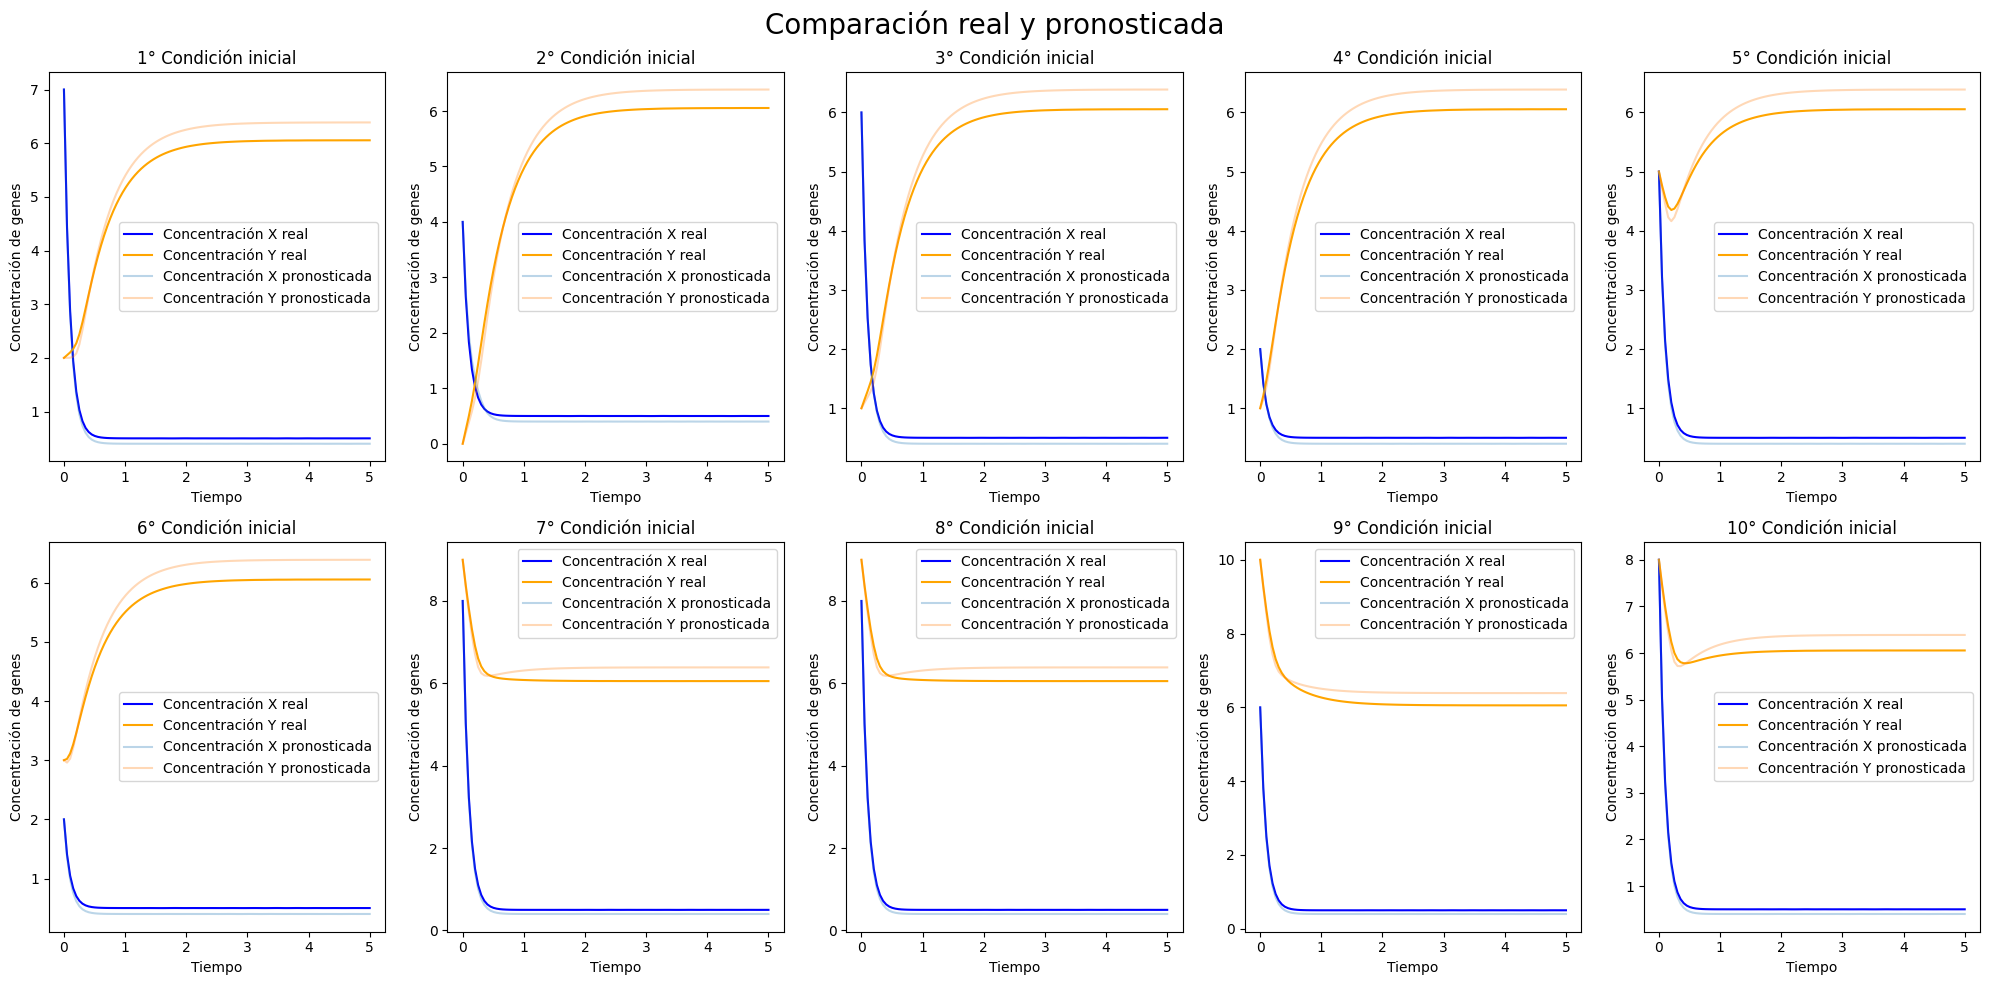

In [56]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

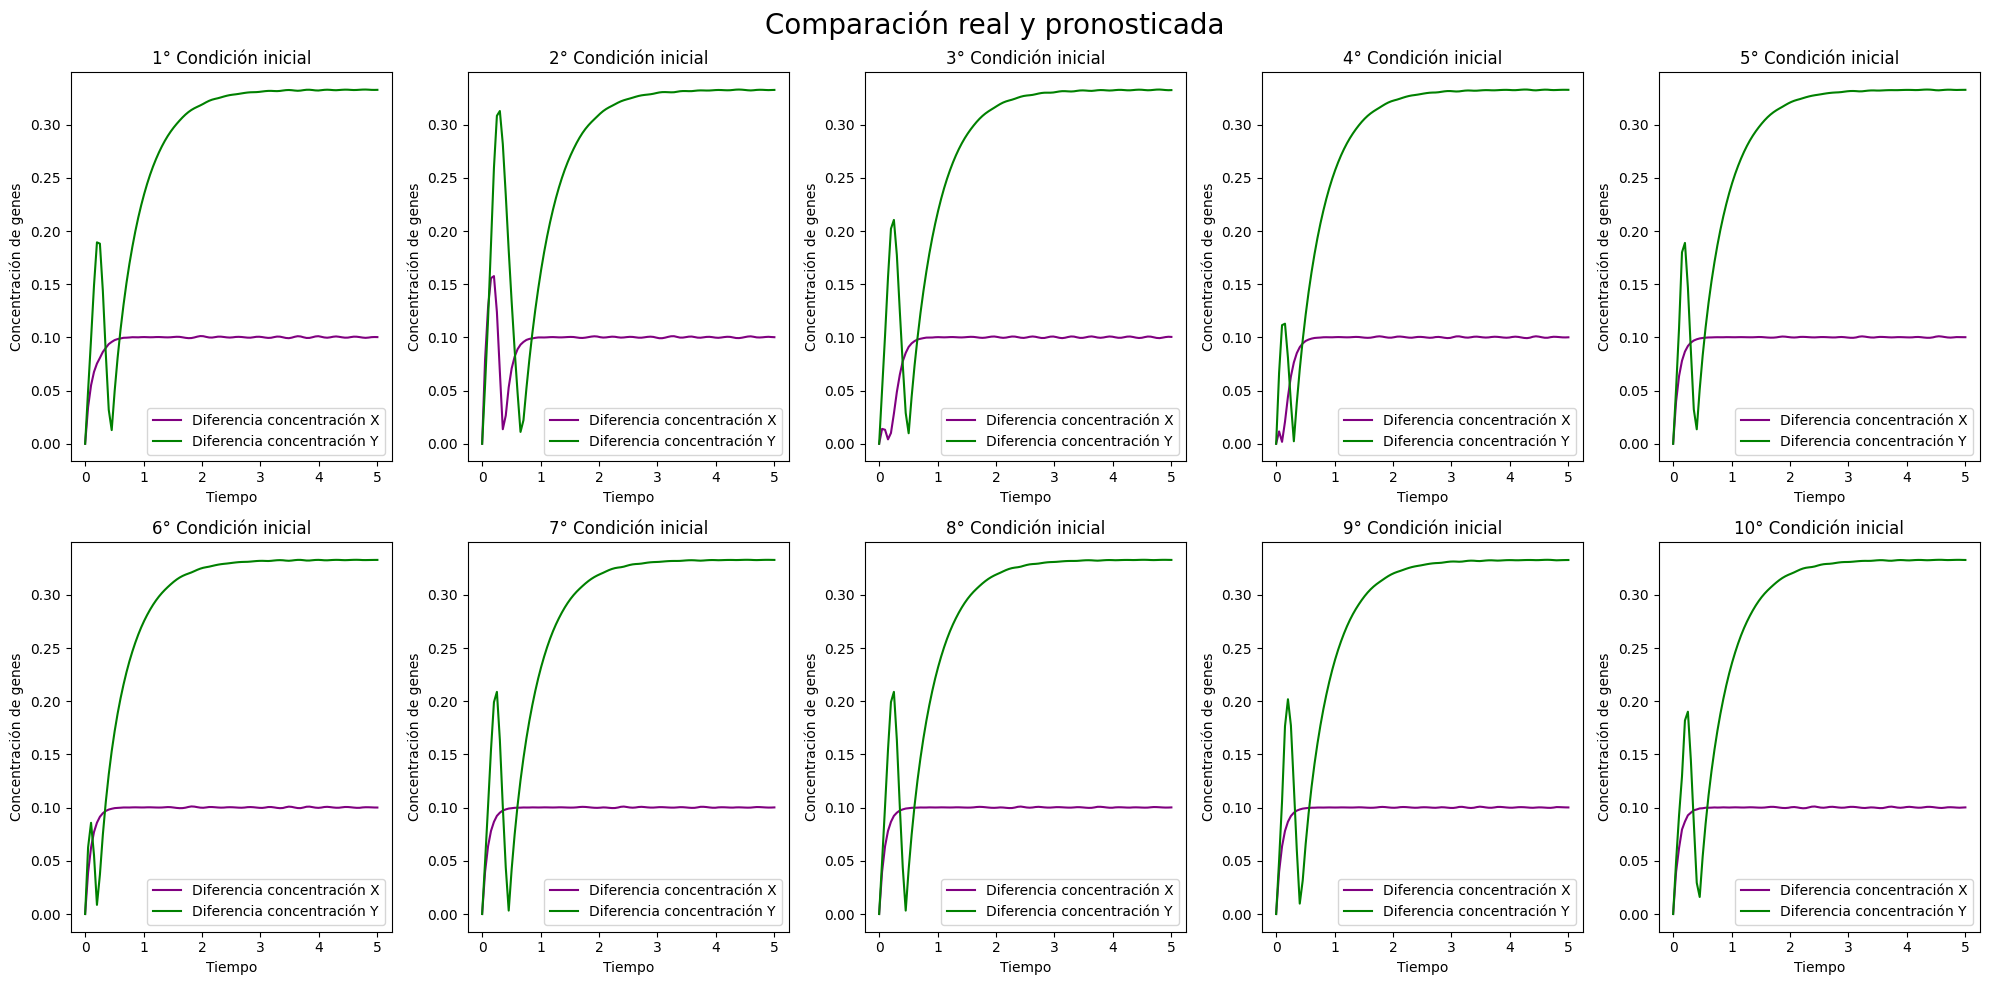

In [57]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.abs(np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :])
    diff_Y = np.abs(np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :])
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [58]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.048441966872410105
0.14085278985955624
